In [1]:
import geopandas
import numpy as np
import pandas as pd
import contextily as cx
from matplotlib import pyplot as plt
import osmnx as ox
import algo
import os
import pickle

# Read data: population

In [2]:
df_population = pd.read_excel('test_data.xlsx', sheet_name='Population')
print(df_population.info())
df_population.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12752 entries, 0 to 12751
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lat                12752 non-null  float64
 1   lon                12752 non-null  float64
 2   metric population  12752 non-null  float64
dtypes: float64(3)
memory usage: 299.0 KB
None


,lat,lon,metric population
0,50.435976,30.625646,1.957358
1,50.435185,30.626106,1.948965
2,50.436381,30.626037,1.698104
3,50.436153,30.626818,2.087091
4,50.435430,30.626640,2.133889


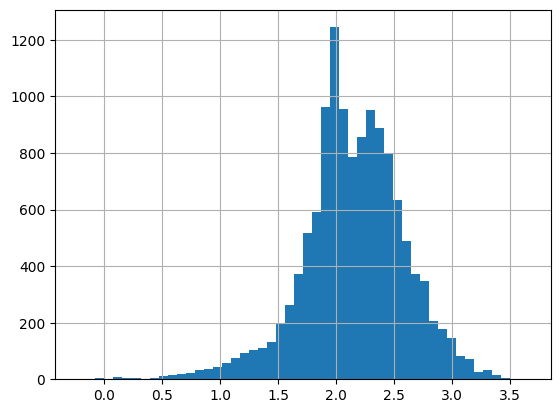

In [3]:
df_population["metric population"].hist(bins=50)
plt.show()

In [4]:
df_population.rename(columns={"lon": "long"}, inplace=True)

# Read data: stores

In [5]:
df_store = pd.read_excel('test_data.xlsx', sheet_name='Stores')
print(df_store.info())
df_store.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         92 non-null     object 
 1   lat           92 non-null     float64
 2   long          92 non-null     float64
 3   Metric Store  92 non-null     float64
dtypes: float64(3), object(1)
memory usage: 3.0+ KB
None


,Store,lat,long,Metric Store
0,Store 1,50.415258,30.522344,2.182985
1,Store 2,50.495292,30.512299,2.636889
2,Store 3,50.414301,30.650869,2.503791
3,Store 4,50.471703,30.478740,2.376577
4,Store 5,50.532248,30.608288,2.340841


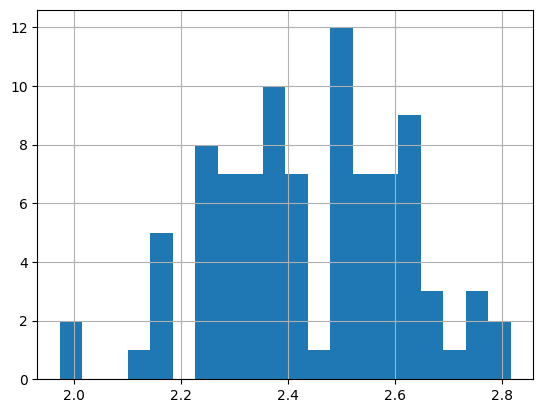

In [6]:
df_store["Metric Store"].hist(bins=20)
plt.show()

In [7]:
df_store.rename(columns={"Metric Store": "metric store"}, inplace=True)

# Visualisation on a map

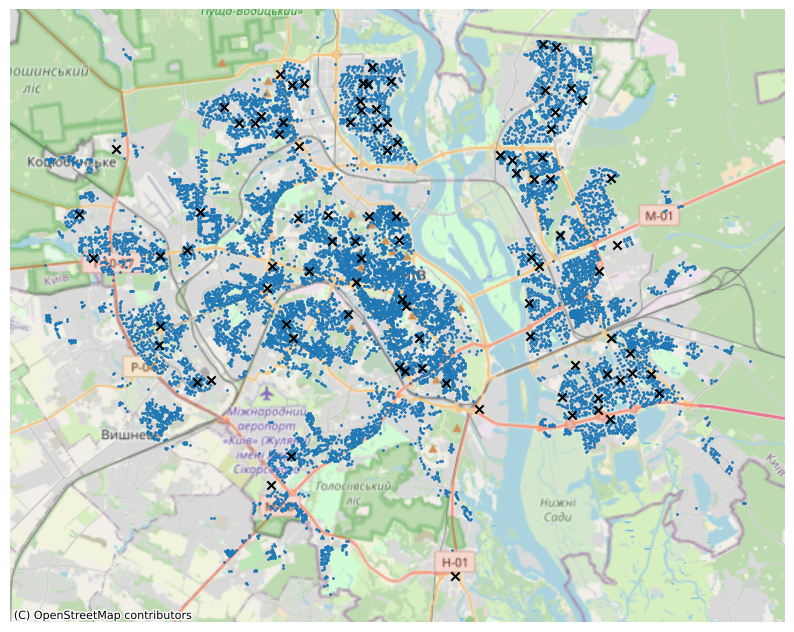

In [8]:
df_store_geo = geopandas.GeoDataFrame(df_store, geometry=geopandas.points_from_xy(df_store["long"], df_store["lat"]), crs='EPSG:4326').to_crs(epsg=9821)
df_population_geo = geopandas.GeoDataFrame(df_population, geometry=geopandas.points_from_xy(df_population["long"], df_population["lat"]), crs='EPSG:4326').to_crs(epsg=9821)

fig, ax = plt.subplots(figsize=(10, 10))
ax = df_population_geo.plot(ax=ax, markersize=1)
ax = df_store_geo.plot(ax=ax, color="k", marker='x')
cx.add_basemap(ax, crs=df_store_geo.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

# Metric visualisation

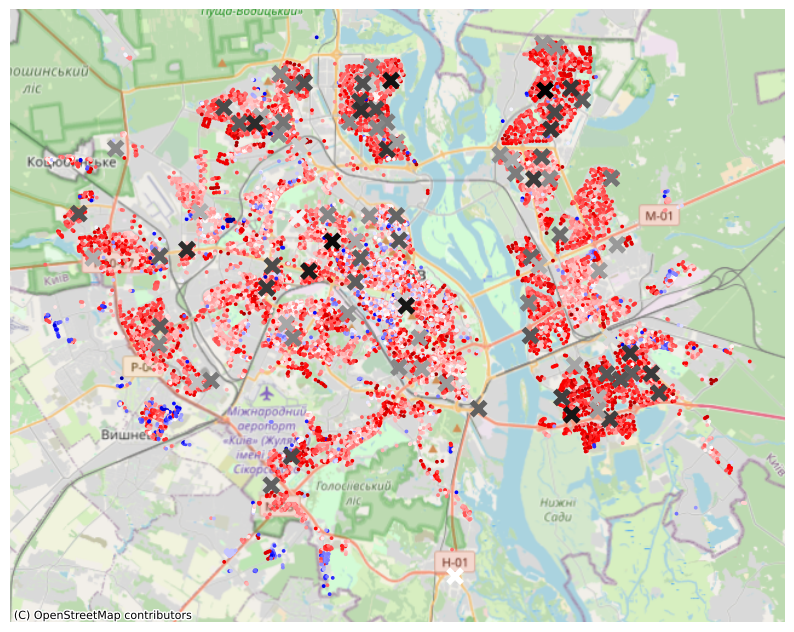

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = df_population_geo.plot(ax=ax, column="metric population", markersize=3, cmap="seismic")
ax = df_store_geo.plot(ax=ax, column="metric store", markersize=100, cmap="binary", marker='x', lw=4)
cx.add_basemap(ax, crs=df_store_geo.crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

# Analyse metrics according to customer-store relation
### To attach each customer to a store, I find the closest store to each customer
### First, I build a route from each customer to each store, and then assign the total distance length as link between points
# Demonstration of building a route

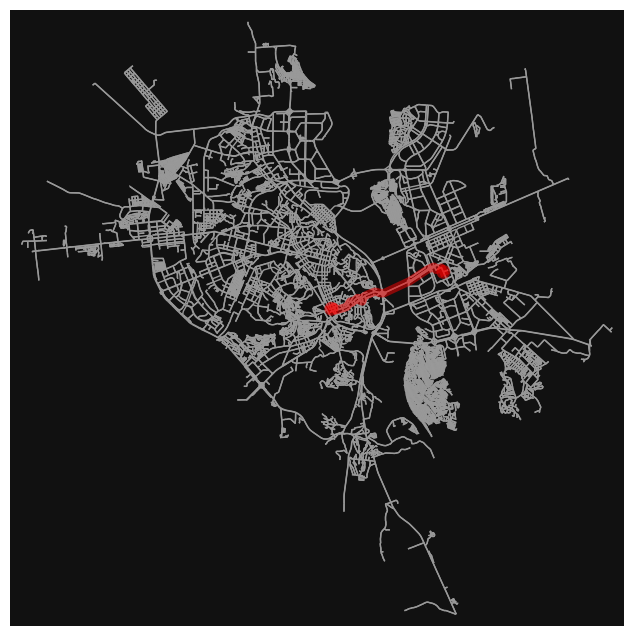

In [10]:
place = "Kyiv, Ukraine"
G = ox.graph_from_place(place, network_type="drive")

# random store coordinates
store_lat, store_lon = 50.415258,30.522344

# random customer coordinates
cust_lat, cust_lon = 50.435976, 30.625646

# fetch the nearest node w.r.t coordinates
store_node = ox.nearest_nodes(G, store_lon, store_lat)
cust_node = ox.nearest_nodes(G, cust_lon, cust_lat)
# find the shortest path
route_nodes = ox.routing.shortest_path(G, store_node, cust_node, weight="length")

# plot the shortes path
fig, ax = ox.plot_graph_route(G, route_nodes, route_color="r",
                              route_linewidth=6, node_size=0)

In [11]:
gdf = ox.graph_to_gdfs(G, edges=False).loc[route_nodes].to_crs(epsg=9821) # crs for Kyiv
distance_m = round(gdf.distance(gdf.shift(1)).sum(), 2)
distance_m # verified the correctness by Google Maps 

8889.1

In [12]:
algo.get_route_distance(orig_point=(store_lon, store_lat), dest_point=(cust_lon, cust_lat), G=G)

8889.1

![verified in Google Maps](screenshot.png)

In [13]:
population = df_population[["long", "lat"]].to_numpy()
stores = df_store[["long", "lat"]].to_numpy()

In [14]:
def route_distance(x, y, G=G):
    return algo.get_route_distance(x, y, G)

### Computing distance for each pair takes very long time. So, I look for closest route considering only closest stores in euclidian metric sense. First, I try with a sample of 100 samples to test this approach

In [15]:
# define 3 closest stores for each customer
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=3)
neigh.fit(stores)
lab = neigh.kneighbors(population)
euclidian_dist_based_neighbours = lab[1]

In [16]:
sample_size = 100
route_neighbours_dict = {}
for i in range(sample_size):
    close_stores = euclidian_dist_based_neighbours[i]
    dict_stores_dict = {j: route_distance(population[i], stores[j]) for j in close_stores}
    closest_store = min(dict_stores_dict, key=dict_stores_dict.get)
    route_neighbours_dict[i] = (closest_store, dict_stores_dict[closest_store])
route_neighbours = np.array([v[0] for v in route_neighbours_dict.values()])

###  In this sample, only 66% customers are assigned to the same store - by euclidian distance and route distance

In [17]:
round((np.array(route_neighbours) == euclidian_dist_based_neighbours[:sample_size, 0]).mean()*100, 2)

66.0

In [18]:
stores_r = np.unique(route_neighbours)
stores_euc = np.unique(euclidian_dist_based_neighbours[:sample_size, 0])

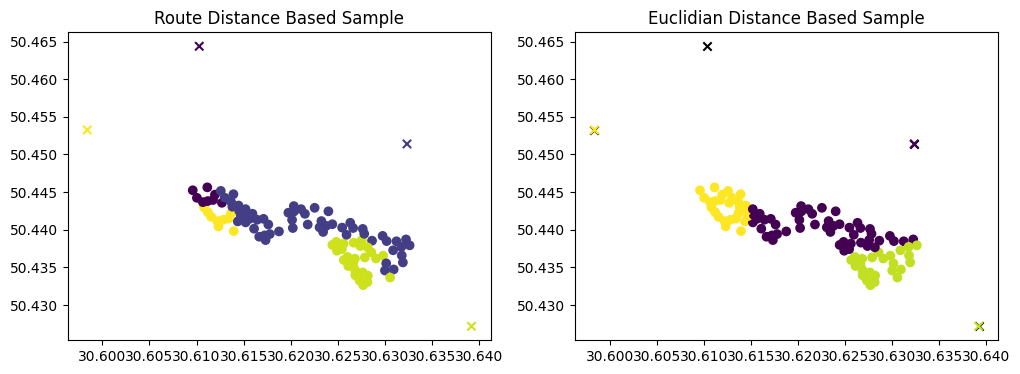

In [19]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(population[:sample_size, 0], population[:sample_size, 1], c=route_neighbours)
plt.scatter(stores[stores_r, 0], stores[stores_r, 1], c=stores_r, marker='x')
plt.title("Route Distance Based Sample")
plt.subplot(122)
plt.scatter(population[:sample_size, 0], population[:sample_size, 1], c=euclidian_dist_based_neighbours[:sample_size, 0])
plt.scatter(stores[stores_r, 0], stores[stores_r, 1], c='k', marker='x')
plt.scatter(stores[stores_euc, 0], stores[stores_euc, 1], c=stores_euc, marker='x')
plt.title("Euclidian Distance Based Sample")
plt.show()

# Final assignment of store for each customer

In [20]:
if "route_neighbours" not in os.listdir('saved_data'):
    route_neighbours_dict = {}
    for i in range(len(population)):
        close_stores = euclidian_dist_based_neighbours[i]
        dict_stores_dict = {j: route_distance(population[i], stores[j]) for j in close_stores}
        closest_store = min(dict_stores_dict, key=dict_stores_dict.get)
        route_neighbours_dict[i] = (closest_store, dict_stores_dict[closest_store])
    pickle.dump(route_neighbours_dict, open("saved_data/route_neighbours", 'wb'))
else:
    route_neighbours_dict = pickle.load(open("saved_data/route_neighbours", 'rb'))
    
route_neighbours = np.array([v[0] for v in route_neighbours_dict.values()])

#### The final function appears in the algo.py

In [21]:
print(f"Proportion of the same assignment by route distance and euclidian distance is {round((np.array(route_neighbours) == euclidian_dist_based_neighbours[:, 0]).mean()*100, 2)} %")

Proportion of the same assignment by route distance and euclidian distance is 65.39 %


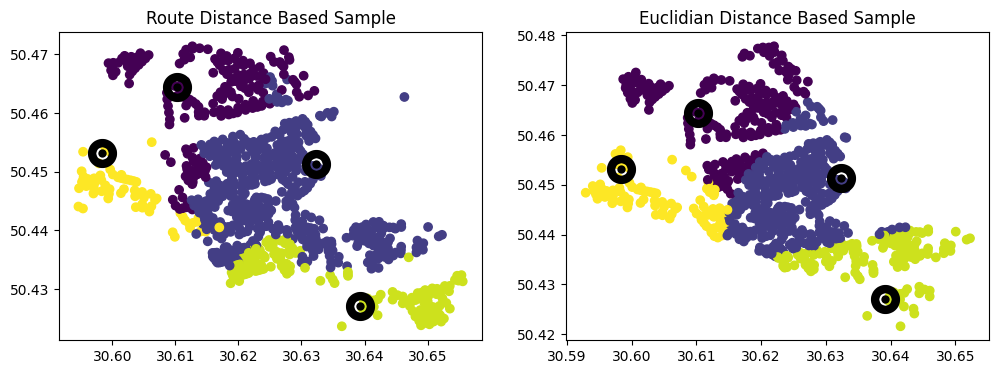

In [22]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
sample_mask = np.in1d(route_neighbours, stores_r)
plt.scatter(population[sample_mask, 0], population[sample_mask, 1], c=route_neighbours[sample_mask])
plt.scatter(stores[stores_r, 0], stores[stores_r, 1], c='k', marker='o', lw=15)
plt.title("Route Distance Based Sample")
plt.subplot(122)
sample_mask = np.in1d(euclidian_dist_based_neighbours[:, 0], stores_r)
plt.scatter(population[sample_mask, 0], population[sample_mask, 1], c=euclidian_dist_based_neighbours[sample_mask, 0])
plt.scatter(stores[stores_r, 0], stores[stores_r, 1], c='k', marker='o', lw=15)
plt.title("Euclidian Distance Based Sample")
plt.show()

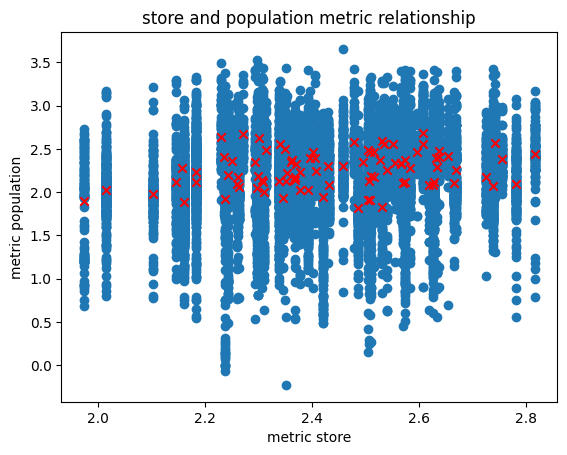

In [23]:
df_population["store_assignment"] = route_neighbours
df_population_s = df_population.merge(df_store[["metric store"]], left_on="store_assignment", how="left", right_index=True)
df_mean = df_population_s.groupby("metric store").apply('mean').reset_index()

plt.scatter(df_population_s["metric store"], df_population_s["metric population"])
plt.scatter(df_mean["metric store"], df_mean["metric population"], marker="x", c='r')
plt.xlabel("metric store")
plt.ylabel("metric population")
plt.title("store and population metric relationship")
plt.show()

In [24]:
df_population_s[["metric store", "metric population"]].corr()

,metric store,metric population
metric store,1.000000,0.136619
metric population,0.136619,1.000000


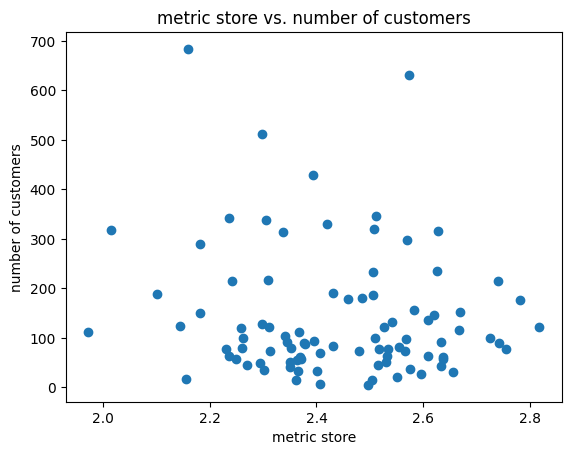

In [25]:
df_len = df_population_s.groupby("metric store")["metric population"].apply(lambda x: len(x)).reset_index()

plt.scatter(df_len["metric store"], df_len["metric population"])
plt.xlabel("metric store")
plt.ylabel("number of customers")
plt.title("metric store vs. number of customers")
plt.show()

In [26]:
df_population = df_population.merge(df_population.groupby(["store_assignment"]).size().rename("customers_per_store"), on="store_assignment", how="left")

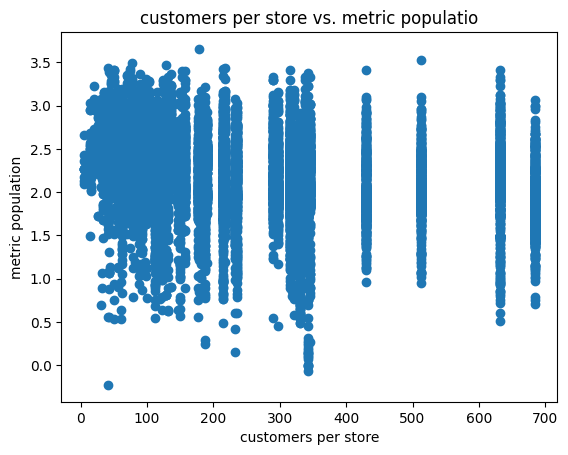

In [27]:
plt.scatter(df_population["customers_per_store"], df_population["metric population"])
plt.xlabel("customers per store")
plt.ylabel("metric population")
plt.title("customers per store vs. metric populatio")
plt.show()

plt.show()

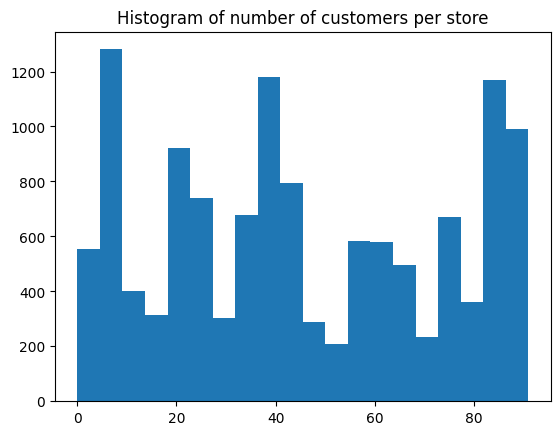

In [28]:
plt.hist(df_population["store_assignment"], bins=20)
plt.title("Histogram of number of customers per store")
plt.show()

In [29]:
df_population["store_assignment"].value_counts()

store_assignment
5     684
38    631
34    512
84    430
19    346
     ... 
52     16
2      15
64     15
69      6
36      5
Name: count, Length: 91, dtype: int64

In [30]:
df_population["dist"] = np.array([v[1] for v in route_neighbours_dict.values()])

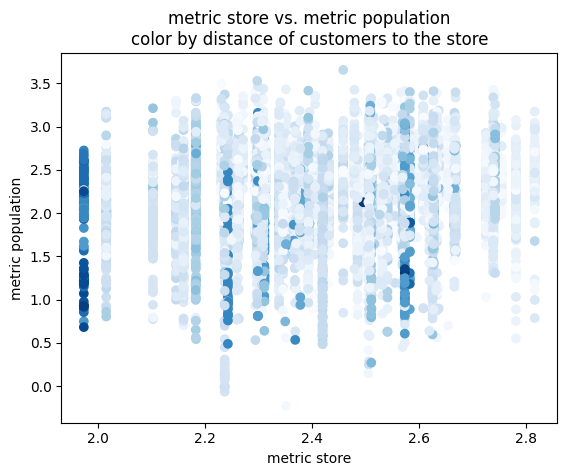

In [31]:
plt.scatter(df_population_s["metric store"], df_population["metric population"], c=df_population["dist"], cmap="Blues")
plt.xlabel("metric store")
plt.ylabel("metric population")
plt.title("metric store vs. metric population\ncolor by distance of customers to the store")
plt.show()

plt.show()

### I couldn't identify any relationships between the population metric and store metric